# PROBLEM 1

In [20]:
from random import uniform
from math import sqrt
from time import time
import numpy

In [21]:
number_of_darts = 200000

In [22]:
def throw_dart():
    x,y = uniform(0,1), uniform(0,1)
    if sqrt((x-0.5)**2+(y-0.5)**2) <= 0.5:
        return 1
    return 0

In [23]:
def count_darts_in_circle_serial(n):
    number_of_darts_in_circle = 0
    for n in range(n):
        number_of_darts_in_circle += throw_dart()
    return number_of_darts_in_circle

In [24]:
def runtime(method, func, n):
    start_time = time()
    count = func(n)
    end_time = time()
    execution_time = end_time - start_time
    pi_approx = 4*count/n
    print(method, '\n')
    print('Pi Approximation:', pi_approx)
    print('Number of Darts:', n)
    print('Execution Time (s):',execution_time)
    print('Darts Thrown per Second:', number_of_darts/execution_time)

In [25]:
runtime('SIMPLE SERIAL', count_darts_in_circle_serial, number_of_darts)

SIMPLE SERIAL 

Pi Approximation: 3.14254
Number of Darts: 200000
Execution Time (s): 0.38481998443603516
Darts Thrown per Second: 519723.52811433584


In [26]:
import multiprocessing

np = multiprocessing.cpu_count()
print('You have {0:1d} CPUs'.format(np))
part_count = [int(number_of_darts/np) for i in range(np)]

You have 4 CPUs


In [27]:
def count_darts_in_circle_multi(n):
    part_count = [int(n/np) for i in range(np)]
    p = multiprocessing.Pool(np)
    count = p.map(count_darts_in_circle_serial, part_count)
    number_of_darts_in_circle = sum(count)
    return number_of_darts_in_circle

In [28]:
runtime('MULTIPROCESSING', count_darts_in_circle_multi, number_of_darts)

MULTIPROCESSING 

Pi Approximation: 3.14614
Number of Darts: 200000
Execution Time (s): 0.22267603874206543
Darts Thrown per Second: 898165.7888735303


In [29]:
import dask as da

def count_darts_in_circle_da(n):
    count = [da.delayed(throw_dart)() for i in range(n)]
    number_of_darts_in_circle = sum(da.compute(*count))
    return number_of_darts_in_circle

In [30]:
runtime('DASK', count_darts_in_circle_da, number_of_darts)

DASK 

Pi Approximation: 3.14026
Number of Darts: 200000
Execution Time (s): 49.416600942611694
Darts Thrown per Second: 4047.2229207400014


In [19]:
import ipyparallel

clients = ipyparallel.Client()
clients.ids
dview = clients.direct_view()

def count_darts_in_circle_parallel(part_count=part_count):
    number_of_darts = dview.map_sync(count_darts_in_circle_serial, part_count)
    return number_of_darts

CompositeError: one or more exceptions from call to method: count_darts_in_circle_serial
[0:apply]: NameError: name 'throw_dart' is not defined
[1:apply]: NameError: name 'throw_dart' is not defined
[2:apply]: NameError: name 'throw_dart' is not defined
[3:apply]: NameError: name 'throw_dart' is not defined

Tried making this work, will come back latter if I have time.   
```python
import ipyparallel as ipp  
rc = ipp.Client()  
ipcluster nbextension enable  
```

# PROBLEM 2

In [12]:
def running_trial(func,ndarts):
    maxdarts = numpy.max(ndarts)
    start = time()
    count = func(ndarts[0])
    exec_time = time()-start
    times = [exec_time]
    for i,n in enumerate(ndarts[1:]):
        count = func(n-ndarts[i])
        exec_time = time()-start
        if n in ndarts:
            times.append(exec_time)
    return times

def many_trials(func,ndarts,ntrials=20):
    trials = numpy.array([running_trial(func,ndarts) for _ in range(ntrials)])
    return trials

def mean_time(trials):
    return numpy.mean(trials,axis=0)

def ci_time(trials):
    low = stats.scoreatpercentile(trials,5,axis=0)
    high = stats.scoreatpercentile(trials,95,axis=0)
    return low,high

In [13]:
ndarts = numpy.logspace(0, 6, 5, dtype=int)
serial_times = running_trial(count_darts_in_circle_serial, ndarts)
multi_times = running_trial(count_darts_in_circle_multi, ndarts)
da_times = running_trial(count_darts_in_circle_da, ndarts)

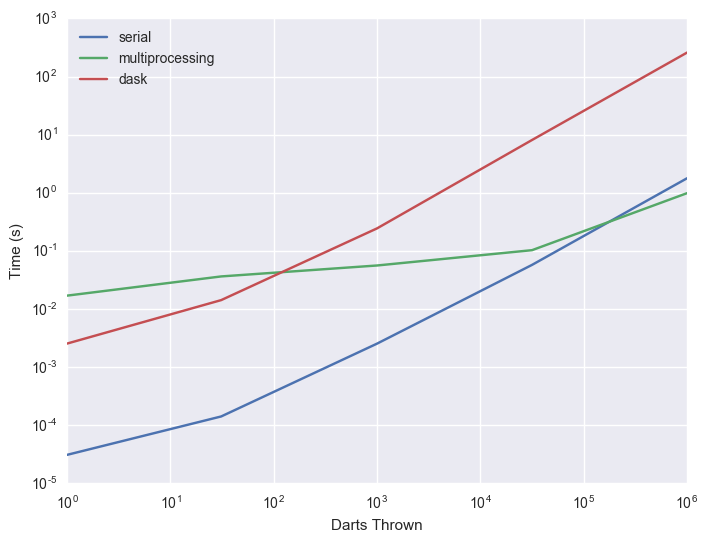

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
plt.loglog(ndarts,serial_times, label='serial')
plt.loglog(ndarts,multi_times, label='multiprocessing')
plt.loglog(ndarts,da_times, label='dask')
plt.legend(loc=2)
plt.ylabel('Time (s)')
plt.xlabel('Darts Thrown')
plt.savefig('dart.png')
plt.show()

# COMPUTER INFO
MacBook Pro  
2.4 GHz Intel Core i5  
4 "cores"  